Deciding between a celebrity look alike with photo classifier and something slightly easier with gender and race classification

[LFW Website](http://vis-www.cs.umass.edu/lfw/#information) <br />
[LFW Dataset and Other Papers](https://paperswithcode.com/dataset/lfw) <br />
[Tensorflow Documentation](https://www.tensorflow.org/datasets/catalog/lfw) <br />
[CONV2D Explanation](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148) <br />
[Image Classification Explanation](https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/) <br />
[LFW Cleaning Data](https://datagen.tech/guides/image-datasets/lfw-dataset/) 


## Rolling list of links papers that helped me:

[BOLD5000](https://www.nature.com/articles/s41597-019-0052-3) <br />
[HyperParameter Selection](https://ada.liacs.leidenuniv.nl/papers/ShaEtAl19.pdf)<br />
[Activation Functions](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

## Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import warnings
from sklearn import datasets
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Rescaling
from keras.callbacks import EarlyStopping
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import requests
import glob
import os
import torch
import shutil

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.getcwd())
print('Training on',DEVICE)
seed = 9090

C:\Users\quort\OneDrive\Desktop\Data-Analyst-Portfolio\[In-Progress] Neural Network for Celebrity Face Classifier (LFW)
Training on cuda


## Loading Dataset

Gonna be using sklearn instead of tfds to download data now.

In [3]:
#example_txt = 'https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt'

#r = requests.get(example_txt)
#with open('lfw_attributes.txt', 'wb') as f:
#    f.write(r.content)

In [4]:
ds = []

DATASET_PATH ="lfw-deepfunneled/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

In [5]:
for path in glob.glob(os.path.join(DATASET_PATH ,"**", "*.jpg")):
    person = path.split("\\")[-2]
    ds.append({"person":person, "path": path})

ds = pd.DataFrame(ds)
ds = ds.groupby("person").filter(lambda x: len(x) > 20)
ds.head(10)

,person,path
222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
227,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
228,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
229,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
230,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...
231,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...


<AxesSubplot:xlabel='person'>

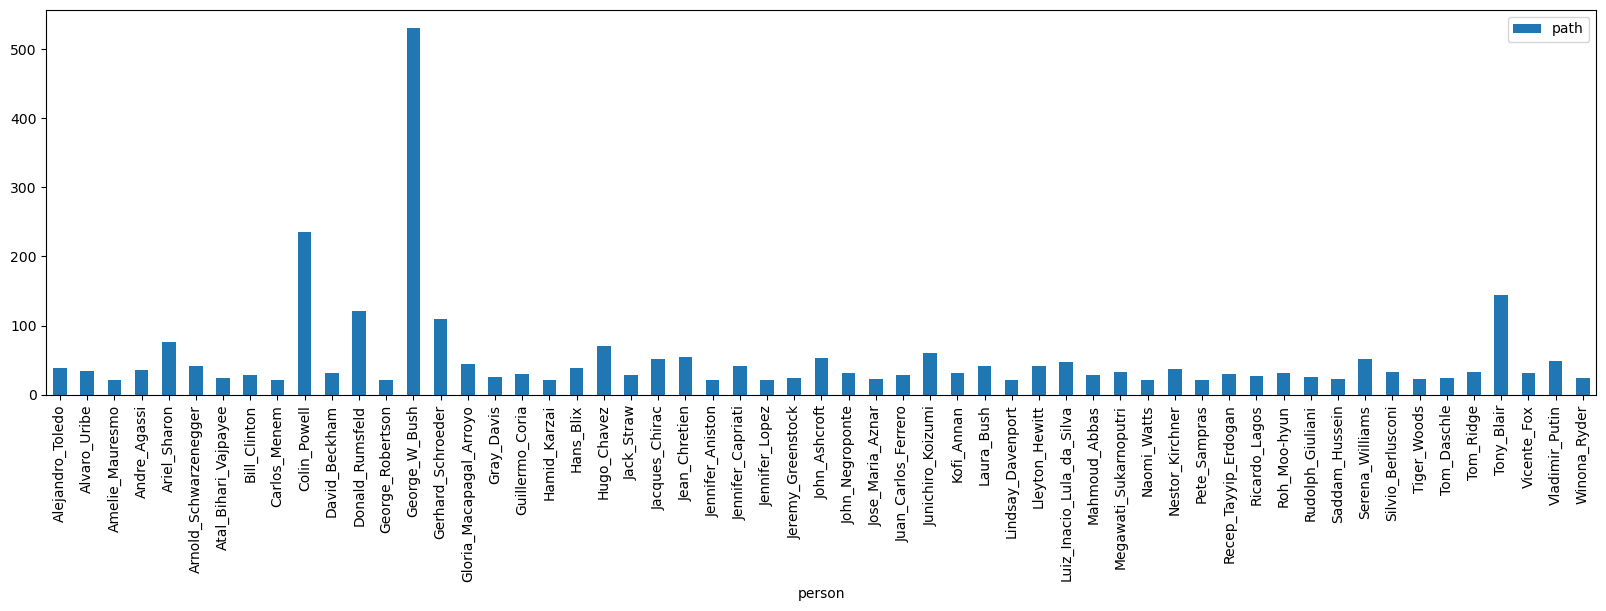

In [6]:
ds.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

In [7]:
unique_labels = ds['person'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())

In [8]:
ds['person_num'] = ds['person'].map(d)
ds

,person,path,person_num
222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
...,...,...,...
13042,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13043,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13044,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56
13045,Winona_Ryder,lfw-deepfunneled\Winona_Ryder\Winona_Ryder_002...,56


## Exploring Data (Using TFDS)

In [9]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
ds_info.features
#Some preprocessing steps are done as the image is normalized to be 250x250

FeaturesDict({
    'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
    'label': Text(shape=(), dtype=tf.string),
})

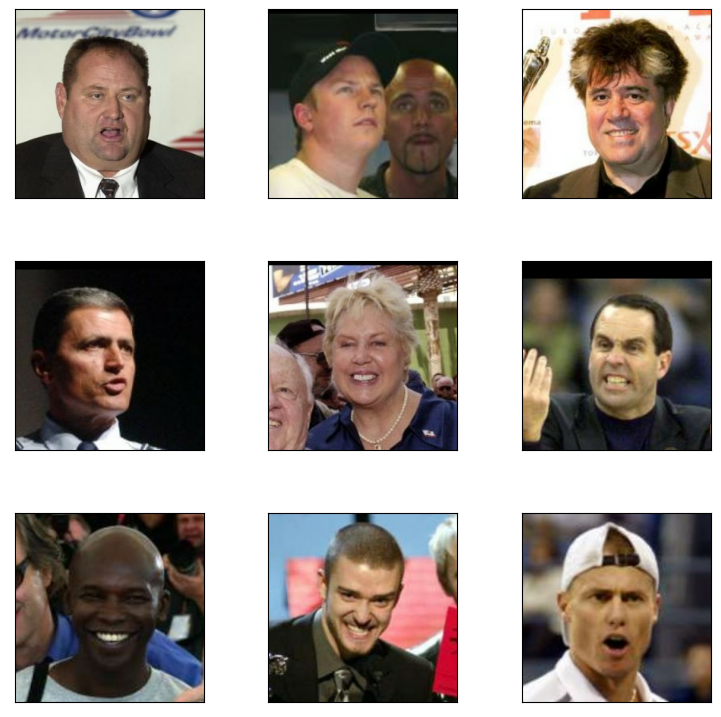

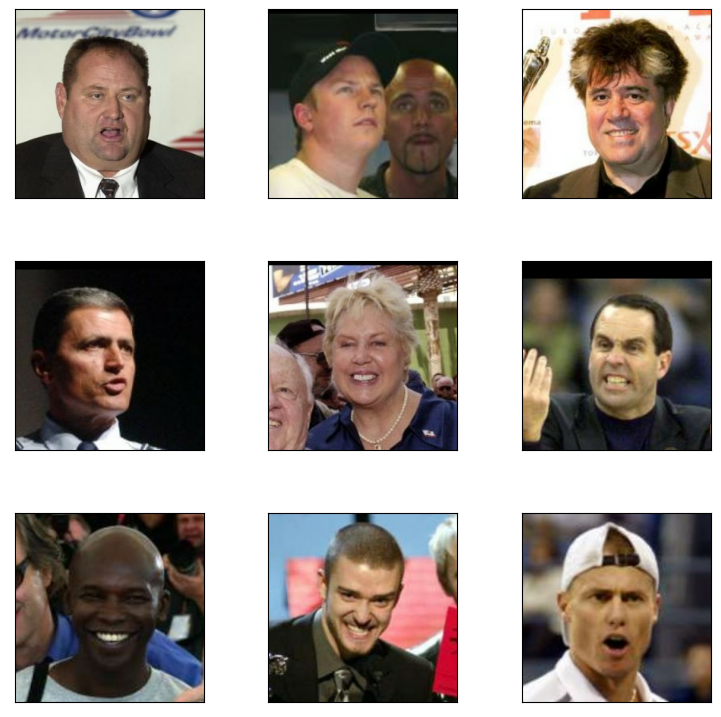

In [10]:
tfds.show_examples(ds, ds_info)

In [11]:
df = tfds.as_dataframe(ds, ds_info)
head = df.head()

In [12]:
head['image']

0    [[[207, 209, 195], [207, 209, 195], [208, 210,...
1    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2    [[[255, 255, 255], [255, 255, 255], [255, 255,...
3    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4    [[[5, 0, 4], [3, 0, 2], [1, 0, 0], [2, 0, 1], ...
Name: image, dtype: object

In [17]:
head['label']

0        b'Tom_Amstutz'
1     b'Kimi_Raikkonen'
2    b'Pedro_Almodovar'
3          b'John_Rosa'
4        b'Jane_Rooney'
Name: label, dtype: object

In [19]:
labels = df['label']

In [22]:
counts = labels.explode().value_counts()
counts = counts.to_frame()
counts = counts.rename({ "label": "counts"}, axis = 1)
counts.index.name = "label"
counts.reset_index(inplace = True)
counts = counts[counts['counts'] > 20]
counts
#top 57 people have 20+ pictures

,label,counts
0,b'George_W_Bush',530
1,b'Colin_Powell',236
2,b'Tony_Blair',144
3,b'Donald_Rumsfeld',121
4,b'Gerhard_Schroeder',109
5,b'Ariel_Sharon',77
6,b'Hugo_Chavez',71
7,b'Junichiro_Koizumi',60
8,b'Jean_Chretien',55
9,b'John_Ashcroft',53


In [21]:
df1 = df[df['label'].isin(counts['label'])]
df1 = df1.reset_index()
df1['label']

0        b'Lleyton_Hewitt'
1         b'George_W_Bush'
2            b'Tim_Henman'
3       b'Lance_Armstrong'
4       b'Donald_Rumsfeld'
               ...        
4169       b'Colin_Powell'
4170      b'George_W_Bush'
4171      b'George_W_Bush'
4172    b'Renee_Zellweger'
4173      b'Mahmoud_Abbas'
Name: label, Length: 4174, dtype: object

In [14]:
for example in ds:
    label, image = example
    if label == counts['label'][1]:
        print(label)
    break

In [9]:
df.head()

,image,label
0,"[[[207, 209, 195], [207, 209, 195], [208, 210,...",b'Tom_Amstutz'
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",b'Kimi_Raikkonen'
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",b'Pedro_Almodovar'
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",b'John_Rosa'
4,"[[[5, 0, 4], [3, 0, 2], [1, 0, 0], [2, 0, 1], ...",b'Jane_Rooney'


In [18]:
labels = df['label']

In [15]:
# train_images = []
# train_labels = []
# i = 0
# #inefficient way of doing it but I wanted to make it work first
# for example in ds:
#     label, image = example
#     for c in counts['label']:
#         i += 1
#         print(i)
#         if label == c:
#             train_images.append(image.numpy())
#             train_labels.append(label.numpy())
#             continue

    

In [16]:
# len(train_images)

In [17]:
# len(train_labels)

## Data Processing

#### other loading methods

In [9]:
#Other data loading method
lfw_train, lfw_test = train_test_split(ds, test_size = 0.2, random_state = seed)
lfw_train, lfw_val =  train_test_split(lfw_train, test_size = 0.2, random_state = seed)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)
print(len(set(lfw_train.person).intersection(set(lfw_test.person))))
print(len(set(lfw_test.person) - set(lfw_train.person)))

#K folds if I want
kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

57
0


C:\Users\quort\AppData\Local\Temp\ipykernel_5004\586254340.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\quort\AppData\Local\Temp\ipykernel_5004\586254340.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


#### loading methods

In [10]:
destination = 'dataset_20plus'
DATASET_PATH ="dataset_20plus/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

batch_size = 32
img_height = 250
img_width = 250

In [11]:
#can parse using the old train and getting thier paths
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2923 files belonging to 57 classes.
Using 2339 files for training.
Found 2923 files belonging to 57 classes.
Using 584 files for validation.


In [12]:
train_images = []
train_labels = []

num_classes = len(train_ds.class_names)

for filename in os.listdir(DATASET_PATH):
    for jpg in os.listdir(DATASET_PATH + "/" + filename):
        if jpg.split('.')[1] == 'jpg':
            p = DATASET_PATH + filename  + "/" + jpg 
            train_labels.append(d[filename])
            img = cv2.imread(p)
            train_images.append(img)

datagen = ImageDataGenerator(rescale=1.0/255.0)
dataset = datagen.flow_from_directory(DATASET_PATH, class_mode='categorical')
X, Y = dataset.next()

Found 2923 images belonging to 57 classes.


In [13]:
class_names = train_ds.class_names
class_names_test =val_ds.class_names
classes = len(train_ds.class_names)
print(len(train_ds.class_names))
print(len(val_ds.class_names))

57
57


Normally, this step would be done by me but LFW has the following in the README.txt

"Each image is a 250x250 jpg, detected and centered using the openCV implementation of Viola-Jones face detector. The cropping region returned by the detector was then automatically enlarged by a factor of 2.2 in each dimension to capture more of the head and then scaled to a uniform size."

**NOTE:** There was two different loading methods used. One of them utilized image_dataset_from_directory and used sparse_categorical_crossentropy. The other loaded the images straight into a df and used binary_crossentropy. My first models was the earlier versions. I will be using the latter version for hyperparameter optimization.

## Modelings

In [32]:
#Performance 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Preliminary Models
#We are working with a 250 x 250 pictures with 3 color channels
#Choosing a simple 1 input layer and 2 hidden layers for now. Will optimize later.
#I will be using relu function for activation,  mean squared error for loss, and adam for optimizer

$$ N_h = \frac{N_s} {(\alpha * (N_i + N_o))} $$
$ Ni $= number of input neurons. <br />
$No$ = number of output neurons.<br />
$Ns$ = number of samples in training data set.<br />
$α $= an arbitrary scaling factor usually 2-10.

[Link](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

[Refreshment on the Math](https://arxiv.org/pdf/1603.07285v1.pdf)

### First model on all data

In [31]:
num_classes = 5749

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(classes, activation='softmax'))
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
#first try

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
331/331 [==============================] - 1146s 3s/step - loss: 8.3449 - accuracy: 0.0354 - val_loss: 8.0906 - val_accuracy: 0.0491
Epoch 2/10
331/331 [==============================] - 1162s 4s/step - loss: 7.4334 - accuracy: 0.0380 - val_loss: 8.5511 - val_accuracy: 0.0480
Epoch 3/10
331/331 [==============================] - 1169s 4s/step - loss: 6.9519 - accuracy: 0.0410 - val_loss: 9.1259 - val_accuracy: 0.0431
Epoch 4/10
331/331 [==============================] - 1168s 4s/step - loss: 6.3421 - accuracy: 0.0488 - val_loss: 11.2238 - val_accuracy: 0.0393
Epoch 5/10
331/331 [==============================] - 1173s 4s/step - loss: 5.2542 - accuracy: 0.1080 - val_loss: 14.0210 - val_accuracy: 0.0306
Epoch 6/10
331/331 [==============================] - 1168s 4s/step - loss: 4.0569 - accuracy: 0.2459 - val_loss: 16.6604 - val_accuracy: 0.0189
Epoch 7/10
331/331 [==============================] - 1177s 4s/step - loss: 3.0556 - accuracy: 0.3910 - val_loss: 21.0633 - val_accur

In [33]:
import pickle
pickle.dump(model, open("model1.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://cabccf85-9172-4b3f-ada0-c5d9af8b1be6/assets


INFO:tensorflow:Assets written to: ram://cabccf85-9172-4b3f-ada0-c5d9af8b1be6/assets


### Second model on filtered data

In [10]:
ds = ds.reset_index()
ds.iterrows()

<generator object DataFrame.iterrows at 0x000001B29BEF8430>

In [11]:
destination = 'dataset_20plus'
DATASET_PATH ="dataset_20plus/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

batch_size = 32
img_height = 250
img_width = 250

for index, item in ds.iterrows():
    path = item['path']
    folder = destination + "/" + str(item['person'])
    if not os.path.exists(folder):
        os.mkdir(destination + "/" + str(item['person']))
    shutil.copy(path, folder)

In [12]:
#can parse using the old train and getting thier paths
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2923 files belonging to 57 classes.
Using 2339 files for training.
Found 2923 files belonging to 57 classes.
Using 584 files for validation.


In [13]:
num_classes = len(train_ds.class_names)
num_classes

57

In [158]:
model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
## add callbacks next time

Epoch 1/5
74/74 [==============================] - 279s 4s/step - loss: 10.8225 - accuracy: 0.1009 - val_loss: 4.0136 - val_accuracy: 0.1764
Epoch 2/5
74/74 [==============================] - 280s 4s/step - loss: 3.8215 - accuracy: 0.1838 - val_loss: 3.6707 - val_accuracy: 0.1952
Epoch 3/5
74/74 [==============================] - 278s 4s/step - loss: 3.3957 - accuracy: 0.2245 - val_loss: 3.6713 - val_accuracy: 0.1866
Epoch 4/5
74/74 [==============================] - 273s 4s/step - loss: 1.7398 - accuracy: 0.5703 - val_loss: 4.0717 - val_accuracy: 0.2312
Epoch 5/5
74/74 [==============================] - 270s 4s/step - loss: 0.1914 - accuracy: 0.9517 - val_loss: 4.2370 - val_accuracy: 0.2860


In [15]:
import pickle
pickle.dump(model, open("model2.pkl", "wb"))

##stopped early since it looked like it was overfitting

INFO:tensorflow:Assets written to: ram://bd3557e6-e133-4da8-b9b5-c00b80c1f636/assets


INFO:tensorflow:Assets written to: ram://bd3557e6-e133-4da8-b9b5-c00b80c1f636/assets


### HyperParameter Testing

#### Grid Search (NA due to ineffciencies)

In [14]:
#Stratified to include all classes in each fold
ds = ds.reset_index()
ds.iterrows()
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

In [15]:
ds.head()

,index,person,path,person_num
0,222,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
1,223,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
2,224,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
3,225,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0
4,226,Alejandro_Toledo,lfw-deepfunneled\Alejandro_Toledo\Alejandro_To...,0


In [16]:
destination = 'dataset_20plus'
DATASET_PATH ="dataset_20plus/"
ATTRIBUTES_PATH = "/lfw_attributes.txt/"

batch_size = 32
img_height = 250
img_width = 250

for index, item in ds.iterrows():
    path = item['path']
    folder = destination + "/" + str(item['person'])
    if not os.path.exists(folder):
        os.mkdir(destination + "/" + str(item['person']))
    shutil.copy(path, folder)

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2923 files belonging to 57 classes.
Using 2339 files for training.
Found 2923 files belonging to 57 classes.
Using 584 files for validation.


In [18]:
train_images = []
train_labels = []

num_classes = len(train_ds.class_names)

for filename in os.listdir(DATASET_PATH):
    for jpg in os.listdir(DATASET_PATH + "/" + filename):
        if jpg.split('.')[1] == 'jpg':
            p = DATASET_PATH + filename  + "/" + jpg 
            train_labels.append(d[filename])
            img = cv2.imread(p)
            train_images.append(img)


In [19]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
dataset = datagen.flow_from_directory(DATASET_PATH, class_mode='categorical')
X, Y = dataset.next()

Found 2923 images belonging to 57 classes.


In [20]:
full_params = {'model__neurons':[16, 32, 64, 128],
        'batch_size':[16, 32, 64, 128], 
        "model__activation" : ['relu', 'tanh', 'sigmoid'],
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        'epochs':[5,10,20],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }


#### epochs

In [23]:
#epochs
def simp_create_model():
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model



model1 =KerasClassifier(model=simp_create_model)

params={'epochs':[5,10,20]}

grid = GridSearchCV(estimator=model1, param_grid=params, error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

In [25]:
params={'epochs':[5,10,20]}

grid = GridSearchCV(estimator=model1, param_grid=params, error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START epochs=5....................................................
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.6845 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 11.3226 - accuracy: 0.0400
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 2.8530 - accuracy: 0.1200
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 2.3793 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 234ms/step
[CV 1/5; 1/3] END .....................epochs=5;, score=0.000 total time=  16.5s
[CV 2/5; 1/3] START epochs=5....................................................
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.7026 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 5.2392 - accuracy: 0.0800
Epoch 3/5
1/1 [==============================] - 3s 3s/st

1/1 [==============================] - 4s 4s/step - loss: 0.0484 - accuracy: 0.6154
Epoch 14/20
1/1 [==============================] - 4s 4s/step - loss: 0.0557 - accuracy: 0.6154
Epoch 15/20
1/1 [==============================] - 3s 3s/step - loss: 0.0414 - accuracy: 0.6538
Epoch 16/20
1/1 [==============================] - 4s 4s/step - loss: 0.0218 - accuracy: 0.8077
Epoch 17/20
1/1 [==============================] - 3s 3s/step - loss: 0.0101 - accuracy: 1.0000
Epoch 18/20
1/1 [==============================] - 3s 3s/step - loss: 0.0084 - accuracy: 1.0000
Epoch 19/20
1/1 [==============================] - 3s 3s/step - loss: 0.0036 - accuracy: 1.0000
Epoch 20/20
1/1 [==============================] - 0s 297ms/step
[CV 3/5; 3/3] END ....................epochs=20;, score=0.000 total time= 1.2min
[CV 4/5; 3/3] START epochs=20...................................................
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.6950 - accuracy: 0.0385
Epoch 2/20
1/1 [==

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.033333 using {'epochs': 5}
0.033333 (0.066667) with: {'epochs': 5}
0.000000 (0.000000) with: {'epochs': 10}
0.000000 (0.000000) with: {'epochs': 20}


#### Batch Size

In [ ]:
def simp_create_model():
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model2 =KerasClassifier(model=simp_create_model, epochs = 5)


full_params = {'model__neurons':[16, 32, 64, 128],
        'batch_size':[16, 32, 64, 128], 
        "model__activation" : ['relu', 'tanh', 'sigmoid'],
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }

params={'batch_size':[16, 32, 64, 128]}
grid = GridSearchCV(estimator=model2, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.057143 using {'batch_size': 64}
0.033333 (0.066667) with: {'batch_size': 16}
0.000000 (0.000000) with: {'batch_size': 32}
0.057143 (0.069985) with: {'batch_size': 64}
0.028571 (0.057143) with: {'batch_size': 128}


#### Model Neurons

In [20]:
def simp_create_model(neurons):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(neurons, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model2 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)


full_params = {'model__neurons':[16,32, 64],
        "model__activation" : ['relu', 'tanh', 'sigmoid'],
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }

params={'model__neurons':[16, 32, 64]}
grid = GridSearchCV(estimator=model2, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START model__neurons=16...........................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6954 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 987ms/step - loss: 3.8717 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 959ms/step - loss: 2.7899 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.7438 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 125ms/step
[CV 1/5; 1/3] END ............model__neurons=16;, score=0.000 total time=   6.4s
[CV 2/5; 1/3] START model__neurons=16...........................................
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.6944 - accuracy: 0.0800
Epoch 2/5
1/1 [==============================] - 1s 962ms/step - loss: 2.3364 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==========================

In [22]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.128571 using {'model__neurons': 16}
0.128571 (0.193781) with: {'model__neurons': 16}
0.090476 (0.117031) with: {'model__neurons': 32}
0.033333 (0.066667) with: {'model__neurons': 64}


#### Model Activation

In [23]:
def simp_create_model(activation = 'relu'):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(16, kernel_size = (3,3), activation = activation, input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(16, kernel_size = (3,3), activation = activation))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model4 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)


full_params = {
        "model__activation" : ['relu', 'tanh', 'sigmoid'],
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }

params={"model__activation" : ['relu', 'tanh', 'sigmoid']}
grid = GridSearchCV(estimator=model4, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START model__activation=relu......................................
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.6934 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 4.2199 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 1.8643 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.7732 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 195ms/step
[CV 1/5; 1/3] END .......model__activation=relu;, score=0.143 total time=   9.7s
[CV 2/5; 1/3] START model__activation=relu......................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7093 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 7.4647 - accuracy: 0.0400
Epoch 3/5
1/1 [==============================] - 1

In [24]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    #even though sigmoid did better, the 100% accuracy is suspicious so I will go relu

Best: 0.100000 using {'model__activation': 'sigmoid'}
0.028571 (0.057143) with: {'model__activation': 'relu'}
0.000000 (0.000000) with: {'model__activation': 'tanh'}
0.100000 (0.200000) with: {'model__activation': 'sigmoid'}


#### optimizer

In [26]:
def simp_create_model(optimizer = 'adam'):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return model

model4 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)


full_params = {
        "optimizer" :['SGD', 'RMSprop','Adam'],
        "optimizer__learning_rate" :[0.001, 0.01, 0.1],
        "optimizer__momentum" : [0.0, 0.2, 0.4, 0.6],
        "model__dropout_rate" : [0.0, 0.1, 0.2, 0.4, 0.6]
        }

params={"optimizer" :['SGD', 'RMSprop','Adam'],}
grid = GridSearchCV(estimator=model4, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START optimizer=SGD...............................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6858 - accuracy: 0.0400
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 5.1145 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 1.5868 - accuracy: 0.2000
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.2508 - accuracy: 0.2000
Epoch 5/5
1/1 [==============================] - 0s 134ms/step
[CV 1/5; 1/3] END ................optimizer=SGD;, score=0.286 total time=   6.6s
[CV 2/5; 1/3] START optimizer=SGD...............................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7035 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 9.2918 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/ste

Epoch 5/5
1/1 [==============================] - 0s 172ms/step
[CV 2/5; 3/3] END ...............optimizer=Adam;, score=0.143 total time=   7.0s
[CV 3/5; 3/3] START optimizer=Adam..............................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6925 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 4.8454 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 1.5953 - accuracy: 0.1538
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.1072 - accuracy: 0.0385
Epoch 5/5
1/1 [==============================] - 0s 151ms/step
[CV 3/5; 3/3] END ...............optimizer=Adam;, score=0.000 total time=   7.5s
[CV 4/5; 3/3] START optimizer=Adam..............................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6989 - accuracy: 0.0385
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 1.47

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.085714 using {'optimizer': 'Adam'}
0.057143 (0.114286) with: {'optimizer': 'SGD'}
0.061905 (0.076190) with: {'optimizer': 'RMSprop'}
0.085714 (0.114286) with: {'optimizer': 'Adam'}


#### Learning Rate and Momentum

In [51]:
def simp_create_model():
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model4 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)

params={"optimizer__learning_rate" :[0.000001, 0.00001,0.0001,0.001, 0.01, 0.1]}
grid = GridSearchCV(estimator=model4, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START optimizer__learning_rate=1e-06..............................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6974 - accuracy: 0.0400
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 3.8201 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 2.9859 - accuracy: 0.0400
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 1.5762 - accuracy: 0.0400
Epoch 5/5
1/1 [==============================] - 0s 141ms/step
[CV 1/5; 1/6] END optimizer__learning_rate=1e-06;, score=0.143 total time=   6.5s
[CV 2/5; 1/6] START optimizer__learning_rate=1e-06..............................
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.6994 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 2.1191 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/st

1/1 [==============================] - 0s 141ms/step
[CV 2/5; 3/6] END optimizer__learning_rate=0.0001;, score=0.000 total time=   6.6s
[CV 3/5; 3/6] START optimizer__learning_rate=0.0001.............................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6958 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 1.2725 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.4978 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.3493 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 141ms/step
[CV 3/5; 3/6] END optimizer__learning_rate=0.0001;, score=0.000 total time=   6.9s
[CV 4/5; 3/6] START optimizer__learning_rate=0.0001.............................
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.6939 - accuracy: 0.0385
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 3.

In [52]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.085714 using {'optimizer__learning_rate': 1e-05}
0.057143 (0.069985) with: {'optimizer__learning_rate': 1e-06}
0.085714 (0.114286) with: {'optimizer__learning_rate': 1e-05}
0.000000 (0.000000) with: {'optimizer__learning_rate': 0.0001}
0.000000 (0.000000) with: {'optimizer__learning_rate': 0.001}
0.057143 (0.069985) with: {'optimizer__learning_rate': 0.01}
0.000000 (0.000000) with: {'optimizer__learning_rate': 0.1}


#### Dropout Rate

In [54]:
def simp_create_model(dropout_rate):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=1e-05)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return model

model4 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)


params={"model__dropout_rate" : [0.0, 0.05, 0.1, 0.15, 0.2,0.3]}
grid = GridSearchCV(estimator=model4, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START model__dropout_rate=0.0.....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7004 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.5888 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.5215 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.4679 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 172ms/step
[CV 1/5; 1/6] END ......model__dropout_rate=0.0;, score=0.000 total time=   7.6s
[CV 2/5; 1/6] START model__dropout_rate=0.0.....................................
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.6977 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.5411 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================]

Epoch 5/5
1/1 [==============================] - 0s 180ms/step
[CV 2/5; 3/6] END ......model__dropout_rate=0.1;, score=0.000 total time=   8.2s
[CV 3/5; 3/6] START model__dropout_rate=0.1.....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.5096 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.4174 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.3613 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 158ms/step
[CV 3/5; 3/6] END ......model__dropout_rate=0.1;, score=0.000 total time=   8.7s
[CV 4/5; 3/6] START model__dropout_rate=0.1.....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7063 - accuracy: 0.0385
Epoch 2/5
1/1 [==============================] - 1s 1s/step - lo

In [55]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.100000 using {'model__dropout_rate': 0.0}
0.100000 (0.200000) with: {'model__dropout_rate': 0.0}
0.061905 (0.076190) with: {'model__dropout_rate': 0.05}
0.000000 (0.000000) with: {'model__dropout_rate': 0.1}
0.000000 (0.000000) with: {'model__dropout_rate': 0.15}
0.000000 (0.000000) with: {'model__dropout_rate': 0.2}
0.000000 (0.000000) with: {'model__dropout_rate': 0.3}


In [56]:
def simp_create_model(dropout_rate):
    model = tf.keras.models.Sequential()
    #model.add(Rescaling(1./255))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,3)))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(1,1)))
    
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=1e-05)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return model

model4 =KerasClassifier(model=simp_create_model, epochs = 5, batch_size = 64)


params={"model__dropout_rate" : [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]}
grid = GridSearchCV(estimator=model4, param_grid=params, 
                    error_score = "raise", scoring = 'accuracy', verbose = 10)

grid_result = grid.fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START model__dropout_rate=0.0.....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7148 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.4892 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.3806 - accuracy: 0.0400
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.3184 - accuracy: 0.0400
Epoch 5/5
1/1 [==============================] - 0s 185ms/step
[CV 1/5; 1/6] END ......model__dropout_rate=0.0;, score=0.000 total time=   7.4s
[CV 2/5; 1/6] START model__dropout_rate=0.0.....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7031 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.5243 - accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 1s

1/1 [==============================] - 2s 2s/step - loss: 0.4751 - accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.4121 - accuracy: 0.0385
Epoch 5/5
1/1 [==============================] - 0s 188ms/step
[CV 4/5; 5/6] END .....model__dropout_rate=0.04;, score=0.000 total time=  10.4s
[CV 5/5; 5/6] START model__dropout_rate=0.04....................................
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.7026 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.5148 - accuracy: 0.1923
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.4076 - accuracy: 0.1923
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 0.3339 - accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 188ms/step
[CV 5/5; 5/6] END .....model__dropout_rate=0.04;, score=0.000 total time=   9.4s
[CV 1/5; 6/6] START model__dropout_rate=0.05.....................

In [57]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Best: 0.061905 using {'model__dropout_rate': 0.05}
0.000000 (0.000000) with: {'model__dropout_rate': 0.0}
0.028571 (0.057143) with: {'model__dropout_rate': 0.01}
0.000000 (0.000000) with: {'model__dropout_rate': 0.02}
0.000000 (0.000000) with: {'model__dropout_rate': 0.03}
0.028571 (0.057143) with: {'model__dropout_rate': 0.04}
0.061905 (0.076190) with: {'model__dropout_rate': 0.05}


### Final Model

In [ ]:
#edited back to becomes sparse categorical crossetropy

In [36]:
model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Dropout(0.05))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [37]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
74/74 [==============================] - 163s 2s/step - loss: 3.7312 - accuracy: 0.1800 - val_loss: 3.6903 - val_accuracy: 0.1781
Epoch 2/10
74/74 [==============================] - 160s 2s/step - loss: 3.5472 - accuracy: 0.1962 - val_loss: 3.5729 - val_accuracy: 0.2003
Epoch 3/10
74/74 [==============================] - 160s 2s/step - loss: 3.3990 - accuracy: 0.2223 - val_loss: 3.4705 - val_accuracy: 0.2106
Epoch 4/10
74/74 [==============================] - 160s 2s/step - loss: 3.2891 - accuracy: 0.2420 - val_loss: 3.4320 - val_accuracy: 0.2175
Epoch 5/10
74/74 [==============================] - 160s 2s/step - loss: 3.1912 - accuracy: 0.2655 - val_loss: 3.3459 - val_accuracy: 0.2277
Epoch 6/10
74/74 [==============================] - 161s 2s/step - loss: 3.0651 - accuracy: 0.2779 - val_loss: 3.3116 - val_accuracy: 0.2586
Epoch 7/10
74/74 [==============================] - 160s 2s/step - loss: 2.9689 - accuracy: 0.2993 - val_loss: 3.3024 - val_accuracy: 0.2586
Epoch 8/10
74

In [38]:
model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Dropout(0.05))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [39]:
#overfitting past 0.33 ish
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
74/74 [==============================] - 161s 2s/step - loss: 6.0344 - accuracy: 0.1672 - val_loss: 3.7082 - val_accuracy: 0.1318
Epoch 2/10
74/74 [==============================] - 161s 2s/step - loss: 3.5654 - accuracy: 0.1967 - val_loss: 3.4765 - val_accuracy: 0.1969
Epoch 3/10
74/74 [==============================] - 162s 2s/step - loss: 2.9253 - accuracy: 0.2937 - val_loss: 3.3110 - val_accuracy: 0.2158
Epoch 4/10
74/74 [==============================] - 161s 2s/step - loss: 1.4139 - accuracy: 0.6345 - val_loss: 3.5009 - val_accuracy: 0.3253
Epoch 5/10
74/74 [==============================] - 162s 2s/step - loss: 0.3466 - accuracy: 0.9098 - val_loss: 4.8085 - val_accuracy: 0.3322
Epoch 6/10
24/74 [========>.....................] - ETA: 1:48 - loss: 0.0943 - accuracy: 0.9740

KeyboardInterrupt: 

In [40]:
#best i will do for now
model = Sequential()
model.add(Rescaling(1./255))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(16, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Dropout(0.05))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=1e-04)
model.compile(optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
#dont forget you can resuse models lmaoo
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
74/74 [==============================] - 163s 2s/step - loss: 3.8525 - accuracy: 0.1655 - val_loss: 3.6416 - val_accuracy: 0.1764
Epoch 2/10
74/74 [==============================] - 162s 2s/step - loss: 3.4465 - accuracy: 0.2048 - val_loss: 3.6422 - val_accuracy: 0.1986
Epoch 3/10
74/74 [==============================] - 157s 2s/step - loss: 3.1478 - accuracy: 0.2587 - val_loss: 3.2749 - val_accuracy: 0.2397
Epoch 4/10
74/74 [==============================] - 156s 2s/step - loss: 2.7363 - accuracy: 0.3296 - val_loss: 3.1333 - val_accuracy: 0.2757
Epoch 5/10
74/74 [==============================] - 157s 2s/step - loss: 2.3407 - accuracy: 0.4198 - val_loss: 2.9554 - val_accuracy: 0.3065
Epoch 6/10
74/74 [==============================] - 155s 2s/step - loss: 1.8846 - accuracy: 0.5177 - val_loss: 2.8405 - val_accuracy: 0.3356
Epoch 7/10
74/74 [==============================] - 155s 2s/step - loss: 1.5070 - accuracy: 0.6323 - val_loss: 2.6827 - val_accuracy: 0.3459
Epoch 8/10
74

In [ ]:
#nexttime get callbacks and print out the history, organize the code first

## Load Dataset (OLD)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [3]:
ds, ds_info = tfds.load('lfw',split='train', with_info = True, as_supervised = True )
test =  (ds, ds_info)
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts,

## Data Processing (OLD) [Description inside]

This consists of the old data processing that I conducted. I originally downloaded the dataset from TFDS and used that dataset to explore and produce modeling. However, after some many hours trying to input the data into the CNN, I eventually decided to use an actual dataset within my computer instead of the TFDS dataset. There are some reasons why TFDS made it hard to use. 

**New Method:** Download the dataset and keep them within local files instead of downloading the dataset via TFDS.

1. TFDS downloaded the dataset as a tfds dataset which meant I was working with a PrefetchDataset instead of a more normalized version
2. Editing a TensorSpec proved to be difficult. When attempting to use .map and a dictionary to convert the byte values of the labels (strings which of the individual persons), tensorflow would go into graph mode and block all numpy functionalities to work.
3. Since I was having difficulty sectioning the labels, the model would not work with a string output instead of a categorical integer
4. I did not tackle the sectioning of the dataset either. So, even if I were to run the model, some people with <5 pictures would be included and would not have been helpful for identification. 

In [21]:
unique_labels = df['label'].unique()
d = dict(enumerate(map(str, unique_labels)))
d = dict((v,k) for k,v in d.items())
d

{"b'Tom_Amstutz'": 0,
 "b'Kimi_Raikkonen'": 1,
 "b'Pedro_Almodovar'": 2,
 "b'John_Rosa'": 3,
 "b'Jane_Rooney'": 4,
 "b'Mike_Brey'": 5,
 "b'Keith_Brown'": 6,
 "b'Justin_Timberlake'": 7,
 "b'Lleyton_Hewitt'": 8,
 "b'Thomas_Wilkens'": 9,
 "b'Ian_Thorpe'": 10,
 "b'Christine_Todd_Whitman'": 11,
 "b'Yekaterina_Guseva'": 12,
 "b'George_W_Bush'": 13,
 "b'Martha_Stewart'": 14,
 "b'Jesse_James'": 15,
 "b'John_Abizaid'": 16,
 "b'Tim_Henman'": 17,
 "b'Pieter_Bouw'": 18,
 "b'Lance_Armstrong'": 19,
 "b'John_Marburger'": 20,
 "b'Al_Gore'": 21,
 "b'Donald_Rumsfeld'": 22,
 "b'Andy_Roddick'": 23,
 "b'Jeremy_Greenstock'": 24,
 "b'Junko_Tabei'": 25,
 "b'Richard_Haass'": 26,
 "b'Paul_Coppin'": 27,
 "b'Dinah_Turner'": 28,
 "b'Guenter_Verheugen'": 29,
 "b'Princess_Elisabeth'": 30,
 "b'Doug_Collins'": 31,
 "b'Larry_Hahn'": 32,
 "b'Natalie_Cole'": 33,
 "b'Valery_Giscard_dEstaing'": 34,
 "b'Gregory_Hines'": 35,
 "b'Mitt_Romney'": 36,
 "b'Ahmed_Chalabi'": 37,
 "b'Lucio_Gutierrez'": 38,
 "b'Bridgette_Wilson-Sampr

In [100]:
#had to do it without filtering to see if it works
train_ds, val_ds, test_ds= tfds.load('lfw', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised = True)

labels = []
for label, image in train_ds:
    #labels.append(float(d[str(label.numpy())]))
    #print(float(d[str(label.numpy())]))
    print(label)
    break
train_ds

tf.Tensor(b'Tom_Amstutz', shape=(), dtype=string)


<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

In [106]:
print(list(d.keys()))

["b'Tom_Amstutz'", "b'Kimi_Raikkonen'", "b'Pedro_Almodovar'", "b'John_Rosa'", "b'Jane_Rooney'", "b'Mike_Brey'", "b'Keith_Brown'", "b'Justin_Timberlake'", "b'Lleyton_Hewitt'", "b'Thomas_Wilkens'", "b'Ian_Thorpe'", "b'Christine_Todd_Whitman'", "b'Yekaterina_Guseva'", "b'George_W_Bush'", "b'Martha_Stewart'", "b'Jesse_James'", "b'John_Abizaid'", "b'Tim_Henman'", "b'Pieter_Bouw'", "b'Lance_Armstrong'", "b'John_Marburger'", "b'Al_Gore'", "b'Donald_Rumsfeld'", "b'Andy_Roddick'", "b'Jeremy_Greenstock'", "b'Junko_Tabei'", "b'Richard_Haass'", "b'Paul_Coppin'", "b'Dinah_Turner'", "b'Guenter_Verheugen'", "b'Princess_Elisabeth'", "b'Doug_Collins'", "b'Larry_Hahn'", "b'Natalie_Cole'", "b'Valery_Giscard_dEstaing'", "b'Gregory_Hines'", "b'Mitt_Romney'", "b'Ahmed_Chalabi'", "b'Lucio_Gutierrez'", "b'Bridgette_Wilson-Sampras'", "b'Tom_Daschle'", "b'Jean_Carnahan'", "b'Megawati_Sukarnoputri'", "b'Tony_Blair'", "b'John_Allen_Muhammad'", "b'Jose_Viegas_Filho'", "b'Andres_Pastrana'", "b'Kofi_Annan'", "b'Howa

In [118]:
keys_tensor = tf.constant(list(d.keys()))
vals_tensor = tf.constant(list(d.values()))
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1)
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>


In [183]:
def convert(label, image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image, label = convert2(label, image)
    return image, label

def convert2(image, label):
    #label = tf.reshape( label, ( 1, ) )
    label = table.lookup(label)
    #label = tf.reshape( label, () )
    return image, label

In [189]:
a, b = train_ds_1.element_spec
b

TensorSpec(shape=(None,), dtype=tf.int32, name=None)

In [185]:
train_ds_1.element_spec =train_ds_1.element_spec.map(convert2)

AttributeError: 'tuple' object has no attribute 'map'

In [166]:
BATCH_SIZE = 32

train_ds_1 = (train_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))

val_ds_1 = (val_ds
            .cache()
            .map(convert1)
            .batch(BATCH_SIZE))


Tensor("args_1:0", shape=(250, 250, 3), dtype=uint8)
Tensor("Reshape:0", shape=(1,), dtype=string)


AttributeError: in user code:

    File "<ipython-input-139-97495c169150>", line 4, in convert1  *
        image, label = convert2(label, image)
    File "<ipython-input-165-48b711af6d37>", line 9, in convert2  *
        print(table.lookup(label).numpy())

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [164]:
for i,j in train_ds_1.take(1):
    print(i)
    print(j)

tf.Tensor(
[[[[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  [[0.8117648  0.8196079  0.76470596]
   [0.8117648  0.8196079  0.76470596]
   [0.81568635 0.8235295  0.7686275 ]
   ...
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]
   [0.8431373  0.854902   0.78823537]]

  ...

  [[0.11764707 0.1137255  0.09803922]
   [0.1137255  0.10980393 0.09411766]
   [0.1137255  0.10980393 0.09411766]
   ...
   [0.09411766 0.08627451 0.09019608]
   [0.09019608 0.08235294 0.08627451]
   [0.09019608 0.08235294 0.08627451]]

  [[0.11764707 0.1137255  0.098039